This post is about a technique that allows us to use variational message passing on models where the likelihood doesn't have a conjugate prior. There will be a lot of Jax code snippets to make everything as concrete as possible. 

## The Math

Say $X$ comes from a distribution with density $q(X;\theta)$, and we want to find $\theta$ to maximize $E[g(X)]$. While in gradient descent we let $\theta_{t+1}=\theta_t + \alpha \nabla_\theta E[g(X)]$, the *natural gradient* update is $\theta_{t+1}=\theta_t + \alpha F^{-1}\nabla_\theta E[g(X)]$, where $F$ is the *Fisher Information Matrix*. When $q$ is the density for an exponential family (which is the only form of $q$ I will consider here), $F$ is the Hessian of the log normalizer $A(\theta)$.

Variational inference seeks a $\theta$ that maximizes the ELBO $\mathcal{L} = f(\theta) + E_{q_\theta}[\log p(X) - \log q(X)]$ where the expected likelihood $f(\theta) = E_{q_\theta} \log p(y \vert  X)$. When $p$ and $q$ come from an exponential family with statistic $T(X)$ and natural parameters $\eta$ and $\theta$ respectively, taking the gradient of the ELBO gives
$$
\begin{aligned}
\nabla_\theta L &= \nabla_\theta f + \nabla_\theta \langle E[T(X)], \eta - \theta \rangle + \nabla_{\theta} A(\theta) \\
&= \nabla_\theta f + \nabla_\theta \langle \nabla A(\theta), \eta - \theta \rangle + \nabla_{\theta} A(\theta) \\
&= \nabla_\theta f + \nabla_\theta^2A(\theta)(\eta - \theta) \\
\end{aligned}
$$

This means that the natural gradient is $F^{-1} \nabla_\theta f + (\eta - \theta)$. 

When the likelihood is conjugate to the prior, $\log p(y\vert x)$ can be written as $\langle T(X), \phi(y) \rangle + c$, where $c$ does not depend on $x$ and $\phi$ is a transformation of the observations. This means that $\log p(y\vert x) + \log p(x) = \langle T(x), \phi(y) + \eta \rangle + c$. Taking the gradient as above, we get
$$
\begin{align*}
\nabla_\theta L &= \nabla_\theta \langle E[T(X)], \phi(y) + \eta - \theta \rangle + \nabla_{\theta} A(\theta) \\
&= \nabla_\theta^2A(\theta)(\phi(y) + \eta - \theta) \\
\end{align*}
$$

This means that the natural gradient is $\phi(y) + \eta - \theta$; a unit length step along the natural gradient recovers the conjugate update.

When $q$ factors as $q(X_1; \theta_1)q(X_2; \theta_2)$ and non-leaf children in $p$ are always conjugate to their parents, we can update each component separately. Say $f$ is a function of $X_1$ alone, $\eta_1$ is a function of $X_2$, and $\eta_2$  is a constant. The gradient of the ELBO with respect to $\theta_1$ becomes
$$
\begin{align*}
\nabla_{\theta_1} L &= \nabla_{\theta_1} f + \nabla_{\theta_1} \langle E[T(X_1)], E[\eta_1(X_2)] - \theta_1 \rangle + \nabla_{\theta_1} A(\theta_1) \\
&= \nabla_{\theta_1} f + \nabla_{\theta_1}^2A(\theta_1)( E[\eta_1(X_2)] - \theta_1) \\
\end{align*}
$$

Similarly, the gradient for $\theta_2$ is $ \nabla_{\theta_2}^2A(\theta_2)(E[\phi(X_1)] + \eta_2 - \theta_2)$. This coordinate-wise natural gradient update is called "variational message passing". 

We can find $F^{-1} \nabla_\theta f$ by using the "conjugate computation" trick. Let $\hat{\theta}$ be the expected-statistic parameterization corresponding to natural parameters $\theta$. Observe that, by the chain rule:

$$\frac{\partial f}{\partial \theta} = \frac{\partial f}{\partial \hat{\theta}}\frac{\partial \hat{\theta}}{\partial \theta}$$

As $\hat{\theta} = \nabla_\theta A(\theta)$, this simiplies to 
$$\frac{\partial f}{\partial \theta} = \frac{\partial f}{\partial \hat{\theta}} \nabla_\theta^2 A(\theta) $$
So 
$$ \nabla_\theta^{-2} A(\theta) \frac{\partial f}{\partial \theta} = \frac{\partial f}{\partial \hat{\theta}} $$
That is, the natural gradient with respect to the natural parameterization is just the ordinary gradient with respect to the mean parameterization. 

## The Code

To see how this works in practice, consider doing variational inference for a hierarchical latent Gaussian mixture model. Let our observations $y_i$ have log density $f(y_i; \mu_{c_i})$ where $f$ is some complicated function like a neural net and $c_i$ is the known mixture component responsible for $z_i$. The $\mu_j \sim \mathcal{N}(m_{d_j}, \tau_2)$, where $d_j$ is the known mixture component responsible for $\mu_j$, and $m_k \sim \mathcal{N}(0, \tau_3)$.  In our variational approximation, we will assume the $\mu_j$ and $m_k$ are all independently Gaussian distributed with natural parameters $\theta_j$  and $\theta_k$ respectively. Then the natural gradient update for $\mu_j$ is
$$F^{-1} \nabla_{\theta_j} f + \begin{bmatrix} \tau_2 m_{d_j} \\ -\tau_2/2 \end{bmatrix} - \theta_j$$
The update for $m_k$ is
$$\sum_j \begin{bmatrix} \tau_2 E[\mu_j] \\ -\tau_2/2 \end{bmatrix} + \begin{bmatrix} 0 \\ -\tau_3/2 \end{bmatrix} - \theta_k$$

If the number of observations $N$ is large, it may be hard to find $\nabla_{\theta_j} f = \sum_i^N \log p(y_i \vert  \mu_{c_i})$ exactly. In this case, we can take a Monte Carlo estimate $N \nabla_{\theta_j} E_{i \in [N]} \log p(y_i \vert  \mu_{c_i})$. Alternately, we can divide the learning rate by $N$, so that the natural gradient is
$$
F^{-1}_i \nabla_{\theta_i} \log p(y_i \vert  \mu_{c_i}) + \frac{1}{N} \left( \begin{bmatrix} \tau_2 m_{d_j} \\ -\tau_2/2 \end{bmatrix} - \theta_j \right)
$$
The same goes for the sums involved in the variational message passing updates.

In Jax, we’ll represent our posterior distributions in vectorized form; each `Normal` will actually represent a plate of $n$ normal distributions. Plates of distributions will have methods for their means and natural gradient updates.

In [22]:
from typing import NamedTuple
from jaxtyping import Array, Float, Int
import jax, jax.numpy as jnp, jax.random as jr, jax.tree_util as jt, jax.nn
import matplotlib.pyplot as plt, numpy as np
from einops import repeat
import equinox as eqx, equinox.nn as nn, optax, diffrax as dfx
import functools as ft

In [5]:
class Normal(NamedTuple):
    nat_params: Float[Array, "n ... 2"]
    n_obs: Int[Array, "n"]
    lr: jnp.float32
    prior_mean: "Distribution"
    prior_prec: jnp.float32
    parent_ixs: Int[Array, "n"]
        
    def mean(self, ix):
        return -0.5 * self.nat_params[ix, ..., 0] / self.nat_params[ix, ..., 1]

    def mean_params(self, ix):
        prec = -2 * self.nat_params[ix, ..., 1]
        mu = self.mean(ix)
        return jnp.stack((mu, (1 / prec) + jnp.square(mu)), axis=-1)

    def update(self, df, ix):
        mu = self.prior_mean.mean(ix)
        ones = jnp.ones(mu.shape)
        prior_msg = jnp.stack((self.prior_prec * mu,
                               -self.prior_prec * ones / 2), axis=-1)
        onestr = "1 " * len(df.shape[1:])
        n_obs = repeat(self.n_obs, "n -> n " + onestr)
        nat_grad = df + (prior_msg - self.nat_params[ix]) / n_obs[ix]
        self = self._replace(nat_params=self.nat_params.at[ix].add(self.lr * nat_grad))
        parent_df = jnp.stack((self.prior_prec * self.mean(ix), - ones * self.prior_prec / 2), axis=-1)
        prior_mean = self.prior_mean.update(parent_df, self.parent_ixs[ix])
        return self._replace(prior_mean=prior_mean)

We’ll make a helper function to initialize one of these variational posterior plates given a plate of prior distributions. 

In [6]:
def normal(mean_dist, prec, n_obs, parent_ixs, lr, key):
    mean = mean_dist.mean(parent_ixs)
    post_mu = mean + jnp.sqrt(1/prec) * jr.normal(key, mean.shape)
    return Normal(normal_nats(post_mu, prec), n_obs, lr, mean_dist, prec, parent_ixs)

In [7]:
def normal_nats(mu, prec):
    ones = jnp.ones(mu.shape)
    return jnp.stack([prec * mu, -0.5 * prec * ones], axis=-1)

The prior mean for $m_k$ is a delta distribution, so we’ll need a representation of this as well. 

In [8]:
class Delta(NamedTuple):
    val: Float[Array, "k"]

    def mean(self, ix):
        return repeat(self.val, '... -> i ...', i=ix.shape[0])

    def update(self, df, ix):
        return self

In [9]:
colon = slice(None,None,None)

## Example: Simple Nonlinearity

Let the expected likelihood $f$ be a monte carlo estimate of a normal distribution around a transformation of $z$ with precision $\tau_1$. We'll have two $m$s, two $\mu$s for each $m$, and 20 $z$s for each $\mu$. 

In [10]:
TAU3 = 0.1
TAU2 = 1
TAU1 = 5

In [74]:
def init_posteriors(n_obs_ms, n_obs_mus, mu_parents, key):
    key, key2 = jr.split(key, 2)
    m = normal(Delta(jnp.float32(0)), jnp.float32(TAU3), n_obs_ms,
        jnp.zeros(len(n_obs_mus), jnp.int32), 1e-3, key)
    mu = normal(m, jnp.float32(TAU2),
        n_obs_mus, mu_parents, 1e-3, key2)
    return mu

In [75]:
data_key, post_key, obs_key, key = jr.split(jr.PRNGKey(1), 4)
n_obs_ms = jnp.full(2, 2, jnp.int32)
n_obs_mus = jnp.full(4, 20, jnp.int32)
mu_parents = repeat(jnp.arange(2), 'a -> (a b)', b=2)
true_mu_dist = init_posteriors(n_obs_ms, n_obs_mus, mu_parents, data_key)
true_z = true_mu_dist.mean(colon)[:,None] + jnp.sqrt(1 / TAU1) * jr.normal(obs_key, (4, 20))
true_z = jnp.ravel(true_z)
mu = init_posteriors(n_obs_ms, n_obs_mus, mu_parents, post_key)

In [76]:
init_mu = init_posteriors(n_obs_ms, n_obs_mus, mu_parents, post_key)

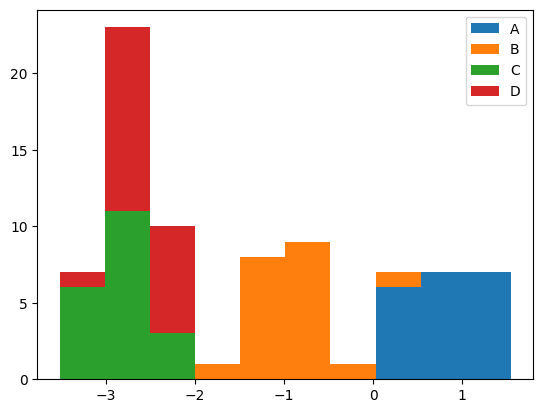

In [77]:
plt.hist(list(jnp.reshape(true_z, (4,20))), stacked=True);
plt.legend(labels=['A', 'B', 'C', 'D']);

We'll keep the nonlinear log likelihood simple for now:

In [78]:
def trans_val(z):
    return jnp.square(z)

In [79]:
@jax.value_and_grad
def f(moments, y, key):
    key, key2 = jr.split(key, 2)
    std = jnp.sqrt(moments[1] - jnp.square(moments[0]))
    mu_sample = moments[0] + std * jr.normal(key, std.shape)
    noise = jnp.sqrt(1 / TAU1) * jr.normal(key2, std.shape)
    z_sample = mu_sample + noise
    obs_lik = -0.5 * jnp.sum(jnp.square(y - trans_val(z_sample)))
    return obs_lik

In [80]:
y = trans_val(true_z)

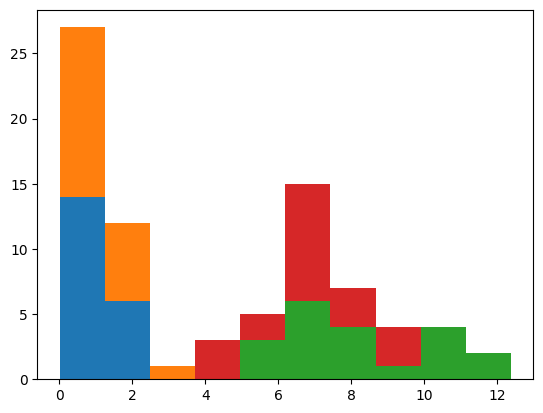

In [81]:
plt.hist(list(jnp.reshape(y, (4, 20))), stacked=True);

Although it's unnecessary for this toy example, we'll process the observations in batches to demonstrate how to handle a big-data setting. 

In [82]:
orig_ixs = repeat(jnp.arange(4), 'a -> (a b)', b=20)

In [83]:
permkey, key = jr.split(key, 2)
ixs = jnp.reshape(jr.permutation(permkey, 80), (4, 20))

In [84]:
@jax.jit
def step(mu, y, noise_key, ix):
    keys = jr.split(noise_key, len(ix))
    oix = orig_ixs[ix]
    logprob, ng = jax.vmap(f)(mu.mean_params(oix), y[ix], keys)
    return -jnp.mean(logprob), mu.update(ng, oix)

In [85]:
for epoch in range(100):
    for ix in ixs:
        noise_key, key = jr.split(key, 2)
        loss, mu = step(mu, y, noise_key, ix)
    if epoch % 10 == 0:
        print("Loss", loss)

Loss 100.12155
Loss 23.347706
Loss 15.448761
Loss 9.154531
Loss 6.0349517
Loss 8.66155
Loss 6.0191417
Loss 6.167668
Loss 3.9419441
Loss 4.059013


In [86]:
true_mu_dist.mean(colon)

Array([ 0.93337744, -0.959161  , -2.7729065 , -2.4498918 ], dtype=float32)

In [87]:
mu.mean(colon)

Array([-1.8313473, -1.6707655,  2.7105517,  2.4046152], dtype=float32)

Inference got pretty close to the true values (up to sign, which isn't identifiable here). Compare this to where we started:

In [88]:
init_mu.mean(colon)

Array([-7.319654  , -6.7709327 ,  1.2107476 ,  0.45153332], dtype=float32)

## Example: Simple Neural Nonlinearity

For a slightly more sophisticated example, let's try to generate some related sin-curves from noise. Our linlinearity will come from a neural net. 

In [89]:
jax.clear_caches()

In [90]:
RES = 64

In [91]:
inputs = jnp.linspace(0, 6, RES)

In [92]:
post_key, net_key, data_key, key = jr.split(jr.PRNGKey(1), 4)

In [93]:
w_base = jnp.array([0.9, 1.15])[None, :]
w_resid = jnp.array([0.4, -0.4])[:, None]
w = w_base + w_base * w_resid
y = jnp.sin(inputs[None] * (w[...,None,None] + 0.02 * (jr.normal(data_key, (2,2,20))[...,None])))
y = jnp.reshape(y, (80, -1))

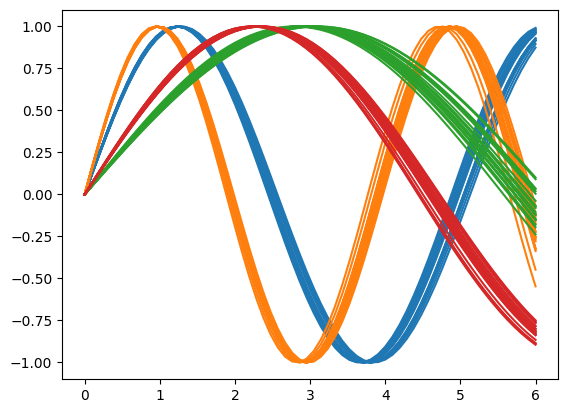

In [96]:
for ix, yi in enumerate(jnp.reshape(y, (4, 20, 64))):
    for yj in yi:
        plt.plot(inputs, yj, f"C{ix}")

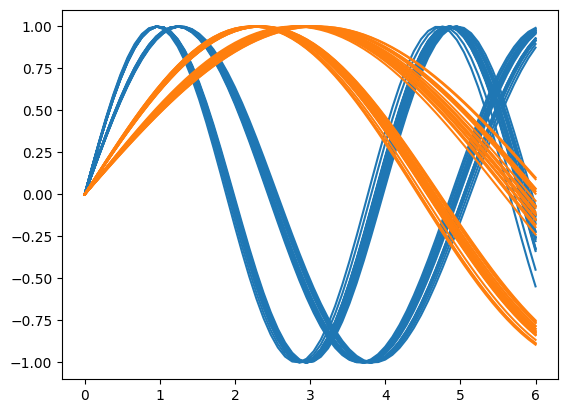

In [97]:
for ix, yi in enumerate(jnp.reshape(y, (2, 40, 64))):
    for yj in yi:
        plt.plot(inputs, yj, f"C{ix}")

In [98]:
def init_posteriors(n_obs_ms, n_obs_mus, mu_parents, key):
    key, key2 = jr.split(key, 2)
    m = normal(Delta(jnp.zeros(RES)), jnp.float32(TAU3), n_obs_ms,
        jnp.zeros(len(n_obs_mus), jnp.int32), 1e-2, key)
    mu = normal(m, jnp.float32(TAU2),
        n_obs_mus, mu_parents, 1e-3, key2)
    return mu

In [99]:
@ft.partial(eqx.filter_vmap, in_axes=((0, None), 0, 0))
@eqx.filter_value_and_grad
def f(args, y, key):
    moments, net = args
    key, key2 = jr.split(key, 2)
    std = jnp.sqrt(moments[:,1] - jnp.square(moments[:, 0]))
    mu_sample = moments[:,0] + std * jr.normal(key, std.shape)
    noise = jnp.sqrt(1 / TAU1) * jr.normal(key2, std.shape)
    z_sample = mu_sample + noise
    obs_lik = -0.5 * jnp.sum(jnp.square(y - net(z_sample)))
    return -obs_lik

In [100]:
@eqx.filter_jit
def step(mu, net, y, noise_key, ix, opt_state, opt_update):
    keys = jr.split(noise_key, len(ix))
    oix = orig_ixs[ix]
    params = mu.mean_params(oix)
    neg_logprob, grads = f((params, net), y[ix], keys)
    ng, net_grads = grads
    net_grad = jt.tree_map(lambda g: jnp.mean(g, axis=0), net_grads)
    updates, opt_state = opt_update(net_grad, opt_state)
    net = eqx.apply_updates(net, updates)
    return jnp.mean(neg_logprob), mu.update(-ng, oix), net, opt_state

In [101]:
mu = init_posteriors(n_obs_ms, n_obs_mus, mu_parents, post_key)
net = nn.MLP(RES, RES, 512, 3, activation=jax.nn.swish, key=net_key) 
lr=1e-3
opt = optax.adabelief(learning_rate=lr)
opt_state = opt.init(eqx.filter(net, eqx.is_inexact_array))

In [102]:
for epoch in range(500):
    for ix in ixs:
        noise_key, key = jr.split(key, 2)
        loss, mu, net, opt_state = step(mu, net, y, noise_key, ix, opt_state, opt.update)
    if epoch % 100 == 0:
        print("Loss", loss)

Loss 4.2189612
Loss 0.064982645
Loss 0.068376474
Loss 0.08926205
Loss 0.060243923


In [103]:
params = mu.mean(colon)

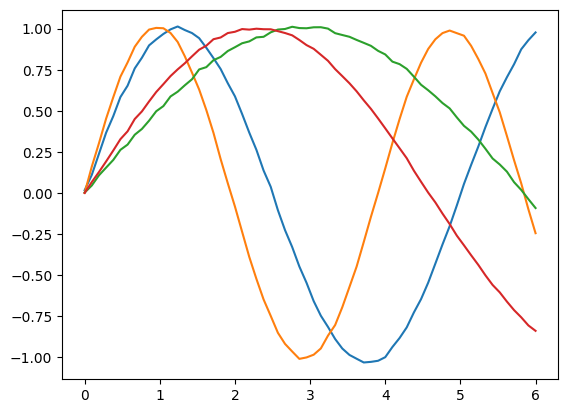

In [104]:
for p in params:
    plt.plot(inputs, net(p))

The distances between $\mu$ values correspond to what we'd assume given the prior.  

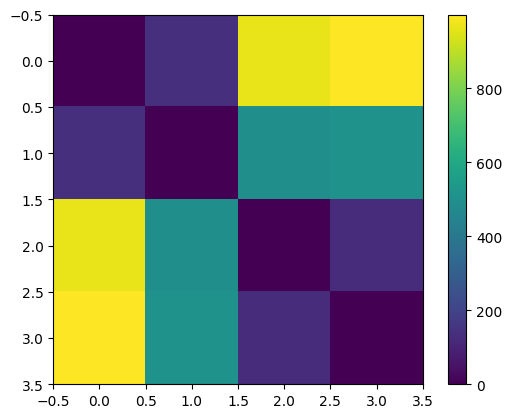

In [105]:
plt.imshow(jnp.sum(jnp.square(params[:, None] - params[None, :]), axis=2))
plt.colorbar()

## Example: Diffusion Nonlinearity

We can try to accomplish the same task using a ODE-based model. We learn a neural network describing a vector field. Integrating along this vector field maps from our latent space to the space of observations.

In [118]:
jax.clear_caches()

In [119]:
@ft.partial(eqx.filter_vmap, in_axes=((0, None), 0, 0))
@eqx.filter_value_and_grad
def f(args, y, key):
    moments, net = args
    key, key2, key3 = jr.split(key, 3)
    std = jnp.sqrt(moments[:,1] - jnp.square(moments[:, 0]))
    mu_sample = moments[:,0] + std * jr.normal(key, std.shape)
    noise = jnp.sqrt(1 / TAU1) * jr.normal(key2, std.shape)
    z_sample = mu_sample + noise
    t = jr.uniform(key3)
    pos = t * y + (1 - t) * z_sample
    target = y - z_sample
    obs_lik = -0.5 * jnp.sum(jnp.square(target - net(t, pos)))
    return -obs_lik

In [120]:
class Net(eqx.Module):
    net: nn.MLP
    def __init__(self, key):
        super().__init__()
        self.net = nn.MLP(RES + 1, RES, 256, 3, activation=jax.nn.swish, key=key) 
    def __call__(self, t, y, *args):
        t = repeat(t, "-> 1")
        return self.net(jnp.concatenate([y, t]))

In [121]:
mu = init_posteriors(n_obs_ms, n_obs_mus, mu_parents, post_key)
lr=1e-3
net = Net(net_key)
opt = optax.adabelief(learning_rate=lr)
opt_state = opt.init(eqx.filter(net, eqx.is_inexact_array))

In [122]:
losses = []
for epoch in range(3000):
    for ix in ixs:
        noise_key, key = jr.split(key, 2)
        loss, mu, net, opt_state = step(mu, net, y, noise_key, ix, opt_state, opt.update)
    if epoch % 100 == 0:
        losses.append(loss)

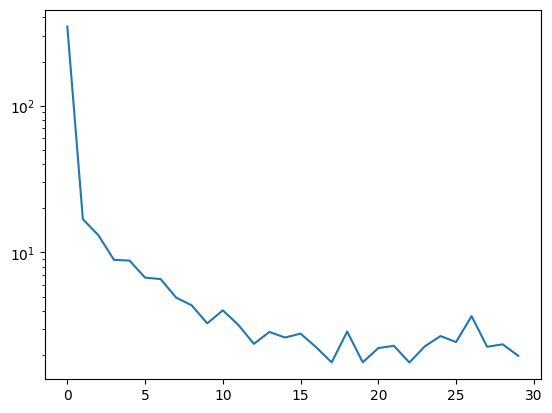

In [124]:
plt.plot(losses)
plt.yscale('log');

In [111]:
params = mu.mean(colon)

In [125]:
@ft.partial(jax.vmap, in_axes=(None, 0))
def forwardflow(net, z):
    term = dfx.ODETerm(net)
    solver = dfx.ReversibleHeun()
    sol = dfx.diffeqsolve(term, solver, 0, 1, 1e-3, z)
    return sol.ys[0]

In [126]:
results = forwardflow(net, params)

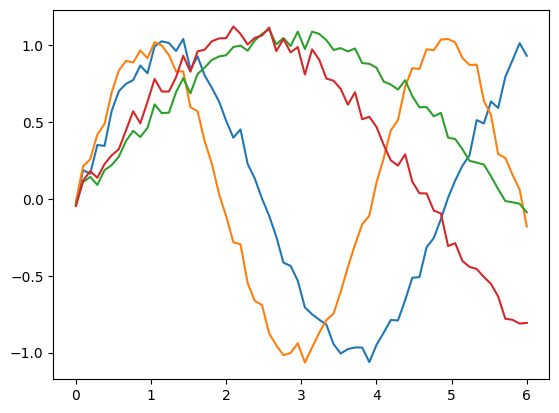

In [127]:
for p in results:
    plt.plot(inputs, p)

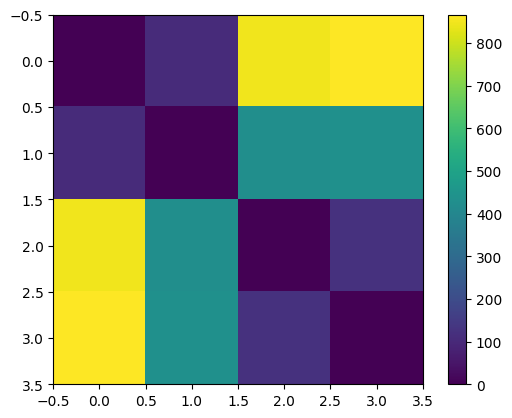

In [128]:
plt.imshow(jnp.sum(jnp.square(params[:, None] - params[None, :]), axis=2))
plt.colorbar()

One of the nice things about ODE models is that we can use them for prediction as well as generation. 

In [129]:
@ft.partial(jax.vmap, in_axes=(None, 0))
def backflow(net, x):
    term = dfx.ODETerm(net)
    solver = dfx.ReversibleHeun()
    sol = dfx.diffeqsolve(term, solver, 1, 0, -1e-3, x)
    return sol.ys[0]

We'll take one sample from each class.

In [130]:
ry = jnp.reshape(y, (4, 20, 64))
topy = ry[:,0,:]

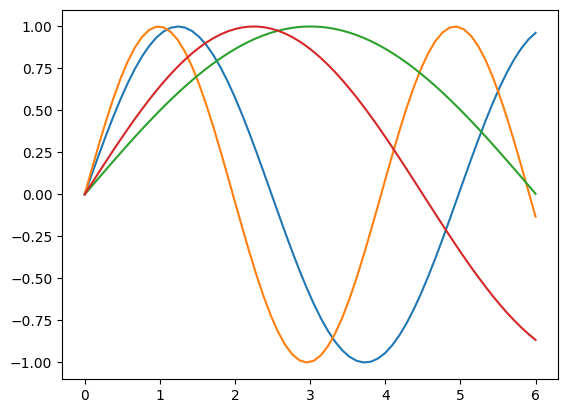

In [131]:
for yi in topy:
    plt.plot(inputs, yi)

We can integrate backwards through time to get the latent code associated with each sample.

In [132]:
zs = backflow(net, topy)

The latent codes are well separated in Euclidean space. 

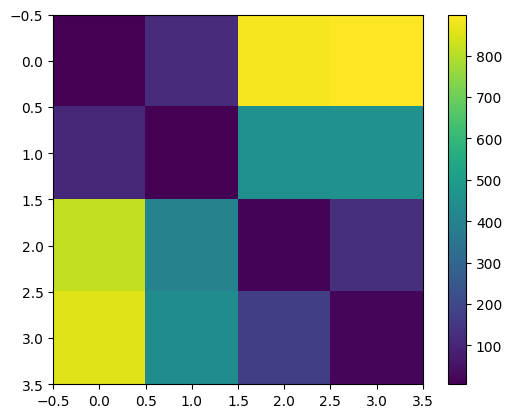

In [135]:
plt.imshow(jnp.sum(jnp.square(zs[:, None] - params[None, :]), axis=2))
plt.colorbar();

We can visualize the embeddings with PCA.

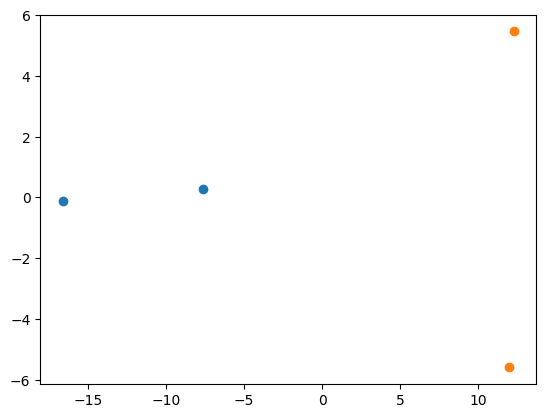

In [137]:
from numpy.linalg import eig
pmu = jnp.mean(params, axis=0)
Xbar = params - pmu[None,:]
S = Xbar.T @ Xbar
res = eig(S)
proj = Xbar @ res[1][:, :2]
plt.scatter(proj[:2, 0], proj[:2, 1])
plt.scatter(proj[2:, 0], proj[2:, 1]);